In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
telco = pd.read_csv('telco.csv')
telco.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


# Data Preprocessing

Transforming the column 'churn' to a binary format ('Yes' = 1, 'No' = 0) for survival analysis and binary classification models.

Also encoding categorical variables 'region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat' into dummy variables for modeling is done.

Next we replace zero values in the 'tenure' column with a small number to avoid issues in model fitting.


In [44]:
telco.set_index('ID', inplace=True)
telco['churn'] = pd.Series(np.where(telco.churn.values == "Yes", 1, 0), telco.index)

encoded_variables = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
surviv_telco = pd.get_dummies(telco, columns = encoded_variables, prefix = encoded_variables, drop_first = True)

surviv_telco["tenure"] = np.where(surviv_telco["tenure"] == 0, 0.000001, surviv_telco["tenure"])

# Fitting Survival Models

Here we apply traditional survival models (Weibull, Exponential, LogNormal, and LogLogistic). Later we will use AFT versions of these models.

Aftwe fitting the models we plot the survival functions of these models for a visual comparison.

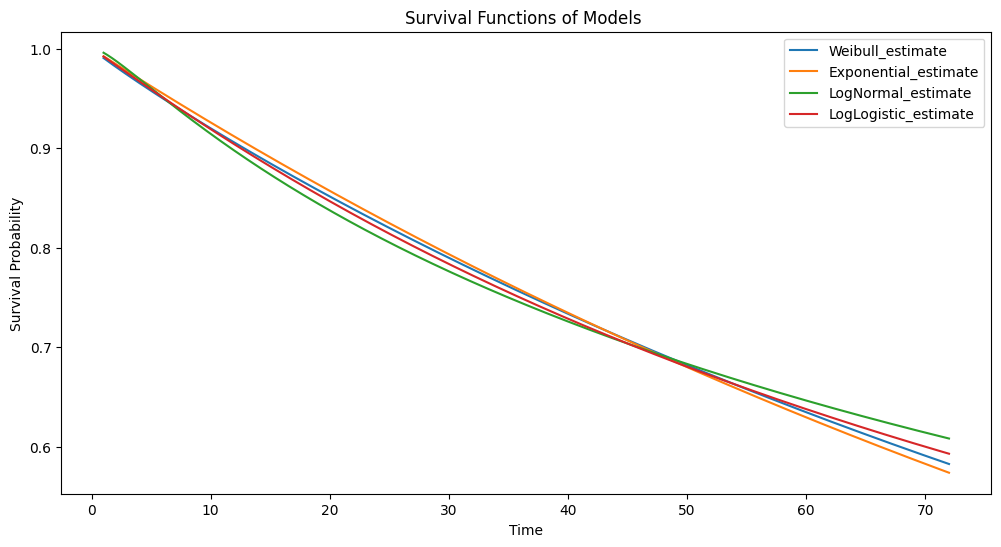

In [45]:
weibul = WeibullFitter()  # Weibull distribution
exponential = ExponentialFitter()  # Exponential distribution
lognormal = LogNormalFitter()  # Log-Normal distribution
loglogistic = LogLogisticFitter()  # Log-Logistic distribution

plt.figure(figsize=(12, 6))
models = [weibul, exponential, lognormal, loglogistic]
for model in models:
    model.fit(durations = telco["tenure"], event_observed = telco["churn"])
    model.plot_survival_function(ci_show=False)
plt.title('Survival Functions of Models ')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Survival curves of those models show a lot of similarity with only small differences. 

In the longrun the LogNormal model shows the highest value of survival probability.


## To compare the performances of each models, we will calculate the AIC and BIC for each model.

In [46]:
metrics = []

for model in models:
    model.fit(durations = surviv_telco['tenure'], event_observed = surviv_telco['churn'])
    metrics.append((model.__class__.__name__, model.AIC_, model.BIC_))

metrics.sort(key=lambda x: x[1]) 

for model_name, aic_value, bic_value in metrics:
    print(f"Performance Metrics For {model_name} Model:\n  AIC: {aic_value}\n  BIC: {bic_value}\n")

Performance Metrics For LogNormalFitter Model:
  AIC: 3209.0351474316735
  BIC: 3218.850657989638

Performance Metrics For LogLogisticFitter Model:
  AIC: 3214.4154757933375
  BIC: 3224.230986351302

Performance Metrics For ExponentialFitter Model:
  AIC: 3215.9608134637247
  BIC: 3220.868568742707

Performance Metrics For WeibullFitter Model:
  AIC: 3216.8611706815464
  BIC: 3226.676681239511



AIC and BIC values show that LogNormalFitter has the lowest AIC = 3209.03 and BIC = 3218.85 compared to other values. Ususlly the model with the lowest AIC or BIC is considered the best fit for the data, so our choice fo the model would be LogNormalFitter for this step.

# Using AFT versions of the models

For this step we will use WeibullAFTFitter, LogNormalAFTFitter, and LogLogisticAFTFitter.  ExponentialAFTFitter model is not available.

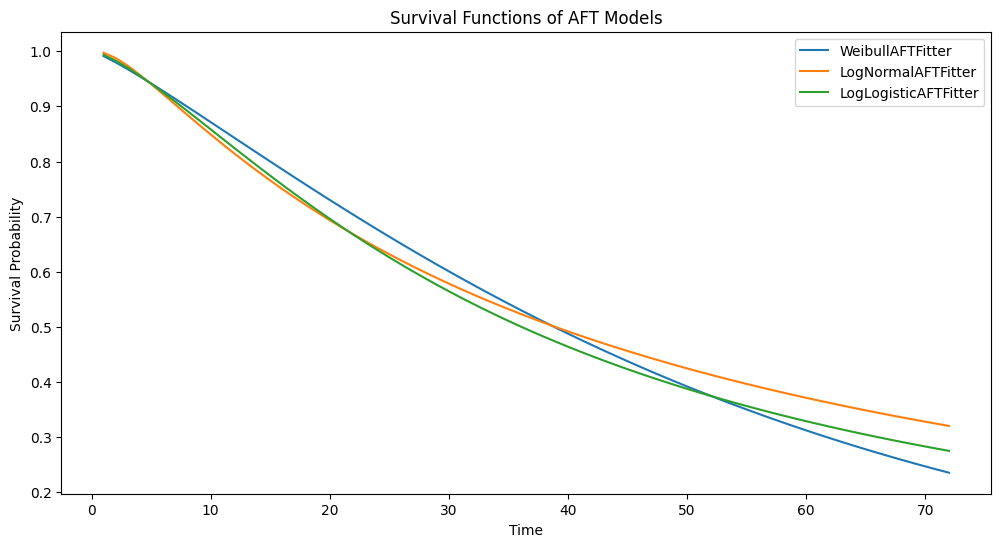

In [47]:
weibul_AFT = WeibullAFTFitter()  # AFT Weibull distribution
lognormal_AFT = LogNormalAFTFitter()  # AFT Log-Normal distribution
loglogistic_AFT = LogLogisticAFTFitter()  # AFT Log-Logistic distribution
models_AFT = [weibul_AFT, lognormal_AFT, loglogistic_AFT]

for model in models_AFT:
    model.fit(surviv_telco, duration_col="tenure", event_col="churn")

covariate_values = surviv_telco.median().to_frame().T

plt.figure(figsize=(12, 6))
for model in models_AFT:
    survival_function = model.predict_survival_function(covariate_values)
    plt.plot(survival_function, label=model.__class__.__name__)
plt.title('Survival Functions of AFT Models')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Survival curves of the AFT models show some differences. In the longrun, the AFT LogNormal model shows the highest value of survival probability. Then comes LogLogistic AFT model. Weibull AFT model is the worst in the sens of survival for the longterm, however for the short term it has higher probability for the survival.

In [48]:
metrics_AFT = []

for model in models_AFT:
    metrics_AFT.append((model.__class__.__name__, model.AIC_, model.BIC_))

metrics_AFT.sort(key=lambda x: x[1]) 

for model_name, aic_value, bic_value in metrics_AFT:
    print(f"Performance Metrics For {model_name} Model:\n  AIC: {aic_value}\n  BIC: {bic_value}\n")

Performance Metrics For LogNormalAFTFitter Model:
  AIC: 2954.0240102517128
  BIC: 2927.839520809677

Performance Metrics For LogLogisticAFTFitter Model:
  AIC: 2956.208561443333
  BIC: 2930.0240720012976

Performance Metrics For WeibullAFTFitter Model:
  AIC: 2964.343248083881
  BIC: 2938.1587586418455



The LogNormalAFTFitter is the best model, having the lowest AIC = 2954 and BIC = 2927 values. This lower values indicate better-fitting models among the provided AFT models.

So remembering the previews results, both LogNormalAFTFitter and LogNormalFitter are considered as the best choices as a model for analyses. Hence we will use LogNormalAFTFitter for future.

In [49]:
lognorm_aft = LogNormalAFTFitter()
lognorm_aft.fit(surviv_telco, duration_col='tenure', event_col='churn')
lognorm_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2024-05-01 19:44:21 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005      

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

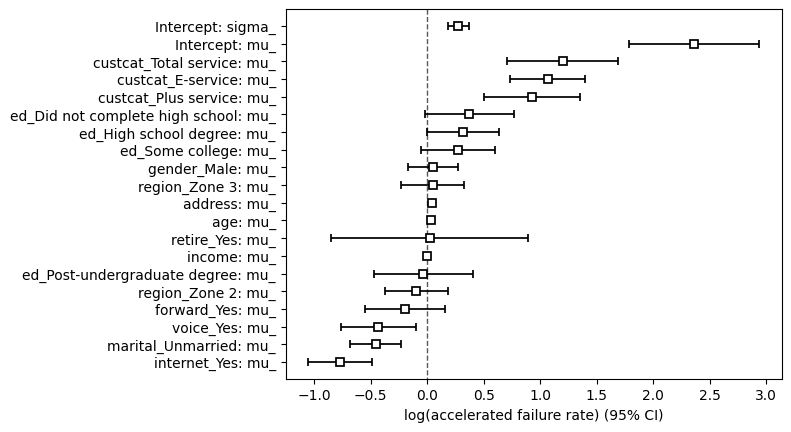

In [50]:
lognorm_aft.plot()

Several variables are as statistically significant. These include 'address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet_Yes', 'marital_Unmarried', 'voice_Yes', and the model intercepts 'Intercept' and 'sigma Intercept'. This is because those variables showed a p-value of less than 0.005, meaning a strong significance in the model. This suggests that these factors are important in predicting customer churn in the telecommunications.

The significant coefficients in survival analysis show the direction and strength of the impact of specific variables on the possibilito of churn. A positive coefficient indicates that an increase in the variable raises the risk of churn, while a negative coefficient suggests a decrease in risk with an increase in the variable. 

In [51]:
# reinitialising the data keeping only significant features
surviv_telco_re = surviv_telco[["tenure", "churn", "address", "age", "custcat_E-service", "custcat_Plus service", "custcat_Total service", "internet_Yes", "marital_Unmarried", "voice_Yes"]]

In [52]:
logn_aft = LogNormalAFTFitter()
logn_aft.fit(surviv_telco_re, duration_col='tenure', event_col='churn')
logn_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2024-05-01 19:44:23 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.78
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

After keeping only the significant features the model is fitted again. And the AIC value has decreased to 2944.20 from 2954.02, showing an improvement in the model's fit.

- 'address' (Coef = 0.04): A positive coefficient suggests that a longer tenure at the same address slightly increases the duration until churn, indicating more stability.
- 'age' (Coef = 0.04): A positive coefficient indicates that older customers are slightly more likely to stay longer before churning.
- 'custcat_E-service' (Coef = 1.03): A large positive coefficient implies that customers in the E-service category are significantly more likely to churn later compared to the base category.
- 'custcat_Plus service' (Coef = 0.82): A positive coefficient suggests that customers in the Plus service category are likely to have a delayed churn compared to the base category.
- 'custcat_Total service' (Coef = 1.01): A positive coefficient indicates that customers in the Total service category are significantly more likely to churn later compared to the base category.
- 'internet_Yes' (Coef = -0.84): The negative coefficient here implies that having internet service is associated with a shorter duration before churning, a factor to consider in retention strategies.
- 'marital_Unmarried' (Coef = -0.45): A negative coefficient suggests that unmarried customers are more likely to churn sooner.
- 'voice_Yes' (Coef = -0.46): This negative value indicates that customers who have subscribed to voice services are at a higher risk of churning sooner.

These results suggest that customer loyalty is influenced by stability (address and tenure) and demographics (age, marital status). Moreover, service types (E-service, Plus, Total)  impact churn too, with internet service increasing churn risk. So, we can see the need for targeted retention strategies, especially for internet and voice service subscribers, and underscores the importance of understanding customer segments for effective business decision-making.

# CLV

In [54]:
clv_predict = lognorm_aft.predict_survival_function(surviv_telco)

In [55]:
prediction = clv_predict.loc[1:12, :]
MM = 1500
r = 0.08
for col in range(1, len(prediction.columns)+1):
    for row in range(1, 13):
        prediction[col][row] = prediction[col][row] / (1 + r / 12)**(row - 1)
telco['CLV'] = MM * prediction.sum(axis = 0)

average_clv_left = telco.loc[(telco["tenure"] <= 12) & (telco["churn"] == 1), "CLV"].mean()
print(f"Average CLV for customers who left within a year: {average_clv_left}")

clv_yearly = telco.loc[(telco["tenure"] <= 12) & (telco["churn"] == 1), "CLV"].sum()
print(f"Yearly CLV of customers who left within a year: {clv_yearly}")

Average CLV for customers who left within a year: 15076.572244533481
Yearly CLV of customers who left within a year: 1583040.0856760156


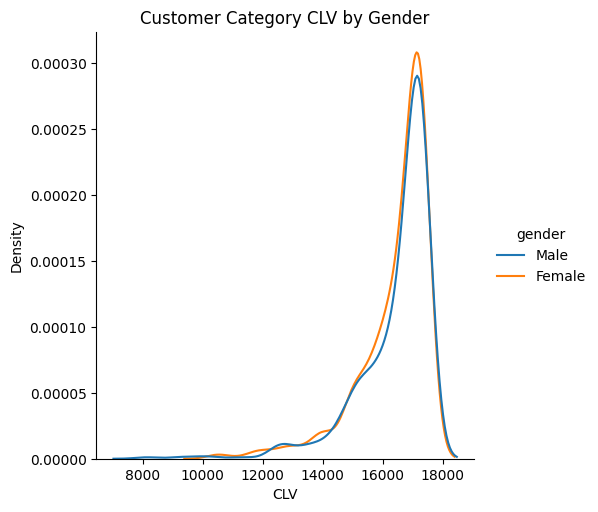

In [56]:
clv_gender = sns.displot(telco, x = 'CLV', kind = 'kde', hue = 'gender')
clv_gender.set(title = 'Customer Category CLV by Gender')

From the above plot we can conclude that in the telecom dataset, both male and female customers have similar CLV distributions, which can mean that gender may not be a the main factor influencing customer value. However, we can see that Female (orange) customers are more likely to survive with a slight difference.

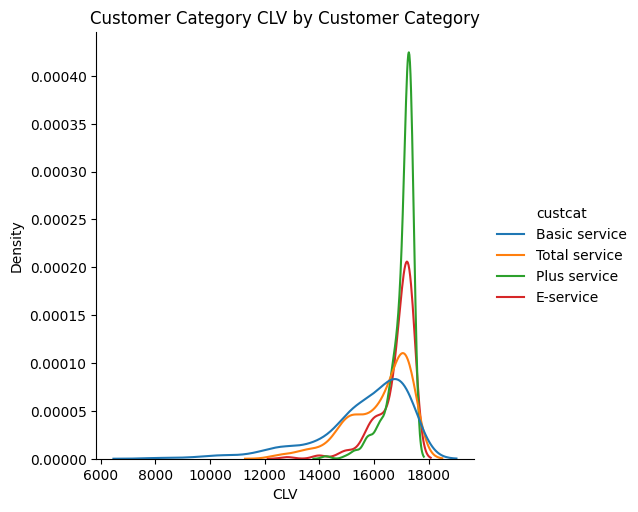

In [57]:
clv_custcat = sns.displot(telco, x = 'CLV', kind = 'kde', hue = 'custcat')
clv_custcat.set(title = 'Customer Category CLV by Customer Category')

Here we can see different CLV distributions among different service categories. The "Plus Service" group shows the highest density and a unimodal distribution, indicating a strong, consistent CLV pattern, which means that they are are most likely to survive. 

The "E-Service" group also displays a unimodal distribution with the second-highest density.  "Total Service" category has the third highest density, and has varied CLV within this segment. 

"Basic Service" group has the lowest density, so they are most likely to churn.  

Conclusion: Customers using "Plus Service" and "E-Service" have high and consistent CLVs. The varied CLV in the "Total Service" group could indicate a mix of highly engaged and less engaged customers. The "Basic Service" users are group with the lowest CLV, can represent a more price-sensitive segment or those with minimal service need. 

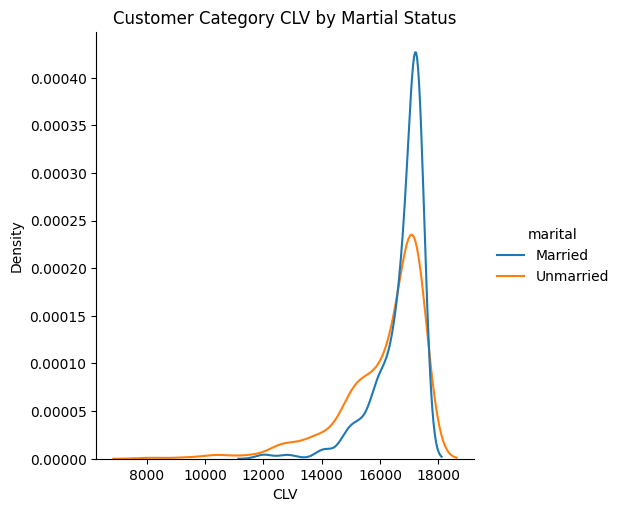

In [58]:
clv_martial = sns.displot(telco, x = 'CLV', kind = 'kde', hue = 'marital')
clv_martial.set(title = 'Customer Category CLV by Martial Status')

Plot shows that the 'married' group performs a higher density value, which can mean that they are more likely to stay and might have more consistent and potentially higher CLV. 

On the other hand, 'unmarried' group has a lower density, indicating a broader range of CLV but generally lower values.

We can conclude that targeting married customers could yield more consistent returns, while strategies for the unmarried group may need to be more diverse and innovative to capture the varied range of their CLV.

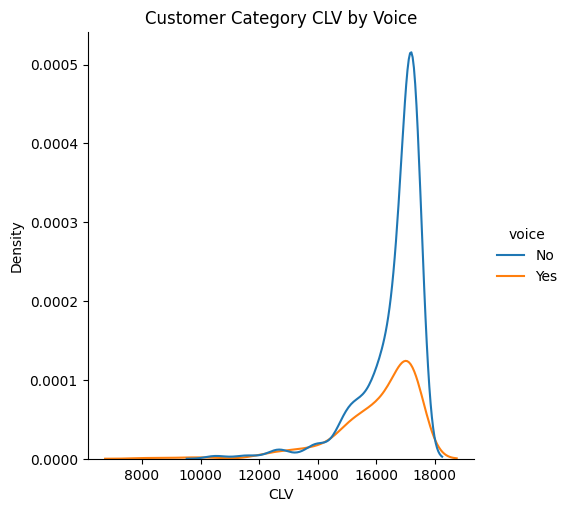

In [61]:
clv_voice = sns.displot(telco, x='CLV', kind='kde', hue='voice')
clv_voice.set(title='Customer Category CLV by Voice')

The visualization depicting "Customer Lifetime Value by Voice" underscores a notable concentration of data points within the "No" category. This clustering implies that a significant proportion of customers lacking voice services exhibit similar CLV patterns, suggesting a cohesive segment within this demographic. This trend could signify a customer base showing less reliance on voice communication, potentially favoring modern forms of interaction such as messaging or internet-based services. Such observations hint at evolving customer preferences, with a considerable subset leaning towards contemporary, data-focused communication methods over conventional voice calls, thereby influencing their collective impact on the company's customer lifetime value.

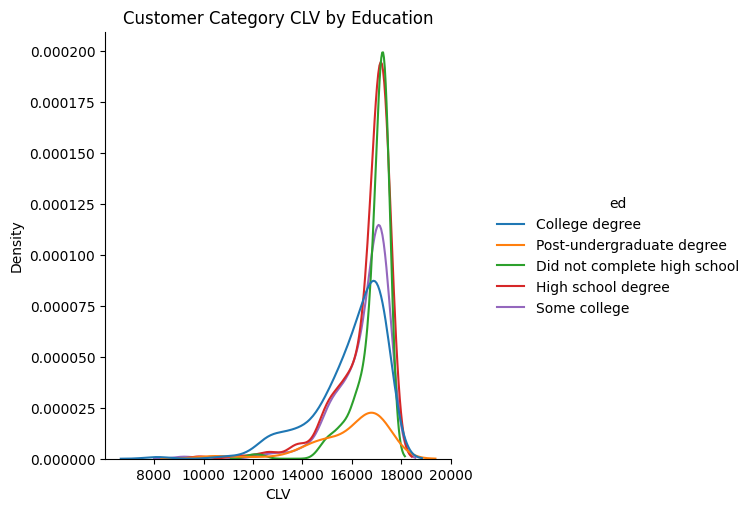

In [59]:
clv_education = sns.displot(telco, x = 'CLV', kind = 'kde', hue = 'ed')
clv_education.set(title='Customer Category CLV by Education')

The plot above shows diverse patterns in the distribution of CLV across different educational groups. The groups with 'High School Degree' and 'Did Not Complete High School' have the highest density. 

'College Degree' and 'Some College' groups share a similar density level and have medium CLV for this feature.

'Post-Undergraduate Degree' group shows the lowest density. 

The higher prevalence of the 'High School Degree' and 'Did Not Complete High School' groups could indicate that younger customers or those with lower educational attainment are more engaged with the business's services.

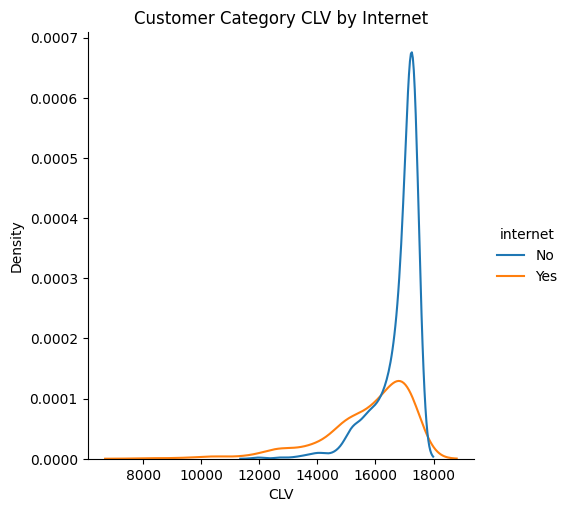

In [60]:
clv_internet = sns.displot(telco, x='CLV', kind='kde', hue='internet')
clv_internet.set(title='Customer Category CLV by Internet')

The plot depicting "Customer Lifetime Value by Internet Connection" reveals a pronounced concentration of data points under the "No" category. This clustering indicates that a notable portion of customers without internet access tends to exhibit comparable and potentially lower levels of CLV. Such a trend suggests the presence of a customer segment less dependent on digital amenities or more sensitive to pricing considerations, opting primarily for fundamental telecom services. This observation mirrors a common scenario where a significant customer cohort favors traditional telecom offerings over enhanced digital connectivity, thereby influencing their long-term value to the company.

# Valuable Customer Segments


*Service Category*

Plus Service and E-Service customers show higher and consistent CLVs, indicating higher engagement and profitability.

*Marital Status*

Married customers have higher and more consistent CLVs, suggesting greater stability and value.

*Educational Level*

Despite varied densities, all groups peak in the same CLV range, but High School Degree and Did Not Complete High School groups are more engaged.

*Internet Service*

Customers without internet service tend to have lower and similar CLVs, indicating a segment less engaged or prioritizing basic telecom services.

*Voice Service*

Customers without voice services often have a clustered lower CLV, suggesting less engagement with traditional voice communication.

# Annual Retention Budget

In [63]:
threshold = 0.8
at_risk_customers = clv_predict.iloc[11][clv_predict.iloc[11] < threshold].count()
cost = 200
annual_retention = at_risk_customers * cost

print("Annual Retention Budget: ${}".format(annual_retention))

Annual Retention Budget: $41000


With a survival probability threshold of 0.8. Assuming a cost of $200  per customer, the annual retention budget would be $41000.

# Suggestions for Retention

For retention strategies, I propose embracing a personalized approach. This entails customizing communication and incentives based on individual customer profiles, usage habits, and preferences. Engaging customers through loyalty programs and offering perks for extended contracts can bolster retention rates. Moreover, establishing feedback channels to glean insights into customer concerns is pivotal. Promptly addressing issues, particularly for high-risk segments, coupled with proactive customer service, can effectively mitigate churn. Leveraging predictive analytics to foresee and prevent potential churn further solidifies retention efforts. This holistic strategy amalgamates theoretical insights with practical expertise in telecommunications customer retention.